
# Bulid a Live Camera App
---

## Step 1 : Data Exploration


### Download
 
This notebook uses the [SVHN](http://ufldl.stanford.edu/housenumbers/) dataset to be used with python experiments.  
SVHN dataset is a good large scale dataset collected from house numbers in Google Street View.

In [180]:
# These are all the modules I'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import pandas as pd
import urllib
import cPickle as pickle
from PIL import Image
import scipy.io as sio
import scipy.io
import h5py
import random
import tensorflow as tf
from sklearn.cross_validation import train_test_split as ttsplit
import math as math

%matplotlib inline

In [17]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def download_data(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print('Failed to verify ' + filename + 'Can you get to it with a browser?')
  return filename

train_filename = download_data('train.tar.gz', 404141560)
test_filename = download_data('test.tar.gz', 276555967)
extra_filename = download_data('extra.tar.gz', 1955489752)

cropped_train_filename = download_data('train_32x32.mat', 182040794)
cropped_test_filename = download_data('test_32x32.mat', 64275384)
cropped_extra_filename = download_data('extra_32x32.mat', 1329278602)

Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz
Found and verified train_32x32.mat
Found and verified test_32x32.mat
Attempting to download: extra_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified extra_32x32.mat


Extract the dataset from the compressed .tar.gz file.

In [18]:
def extract_data(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]
  if os.path.isdir(root) and not force:
    print('%s already present - Skipping extra of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  return root

train_folders = extract_data(train_filename)
test_folders = extract_data(test_filename)
extra_folders = extract_data(extra_filename)

train already present - Skipping extra of train.tar.gz.
test already present - Skipping extra of test.tar.gz.
extra already present - Skipping extra of extra.tar.gz.


--------

----


Samples from cropped training dataset


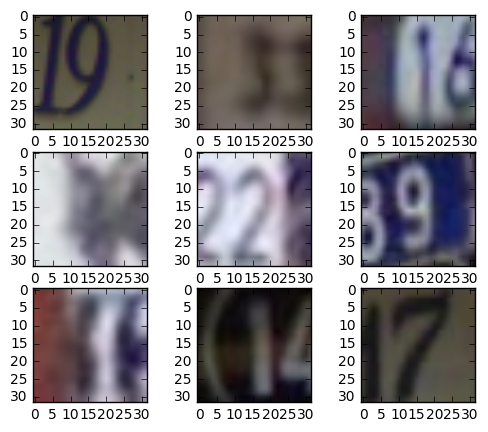

In [19]:
import scipy.io

print("Samples from cropped training dataset")

cropped_train_dataset = scipy.io.loadmat(cropped_train_filename)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(6,5))
ax1.imshow(cropped_train_dataset['X'][:,:,:,1])
ax2.imshow(cropped_train_dataset['X'][:,:,:,10])
ax3.imshow(cropped_train_dataset['X'][:,:,:,20])
ax4.imshow(cropped_train_dataset['X'][:,:,:,30])
ax5.imshow(cropped_train_dataset['X'][:,:,:,40])
ax6.imshow(cropped_train_dataset['X'][:,:,:,50])
ax7.imshow(cropped_train_dataset['X'][:,:,:,60])
ax8.imshow(cropped_train_dataset['X'][:,:,:,70])
ax9.imshow(cropped_train_dataset['X'][:,:,:,80])
plt.show()

In [20]:
# I used udacity's discussion(https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/5) for reference.

class RestructuredDataset:
  def __init__(self, f):
    self.f = h5py.File(f, 'r')
    self.name = self.f['digitStruct']['name']
    self.bbox = self.f['digitStruct']['bbox']

# returns the 'name' string for for the n(th) digitStruct. 
  def get_name(self, n):
    return ''.join([chr(c[0]) for c in self.f[self.name[n][0]].value])

# handles the coding difference when there is exactly one bbox or an array of bbox. 
  def print_attr(self, attr):
    if (len(attr) > 1):
      attr = [self.f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
      attr = [attr.value[0][0]]
    return attr

# returns a dict of data for the n(th) bbox. 
  def get_bbox(self, n):
    bbox = {}
    k = self.bbox[n].item()
    bbox['height'] = self.print_attr(self.f[k]["height"])
    bbox['label'] = self.print_attr(self.f[k]["label"])
    bbox['left'] = self.print_attr(self.f[k]["left"])
    bbox['top'] = self.print_attr(self.f[k]["top"])
    bbox['width'] = self.print_attr(self.f[k]["width"])
    return bbox

  def get_digitStruct(self, n):
    s = self.get_bbox(n)
    s['name']= self.get_name(n)
    return s

# Return a restructured version of the dataset.
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
  def load_data(self):
    digitStruct = [self.get_digitStruct(i) for i in range(len(self.name))]
    dataset = []
    counter = 1
    for i in range(len(digitStruct)):
      item = {'filename' : digitStruct[i]["name"]}
      figures = []
      for j in range(len(digitStruct[i]['height'])):
        ddict = {}
        ddict['height'] = digitStruct[i]['height'][j]
        ddict['label']  = digitStruct[i]['label'][j]
        ddict['left']   = digitStruct[i]['left'][j]
        ddict['top']    = digitStruct[i]['top'][j]
        ddict['width']  = digitStruct[i]['width'][j]
        figures.append(ddict)
      counter += 1
      item['boxes'] = figures
      dataset.append(item)
    return dataset

  def maybe_pickle(self, name, force=False):
    set_filename = name + '.pickle'
    if os.path.exists(set_filename) and not force:
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      data = self.load_data()
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)

In [21]:
f = os.path.join('train', 'digitStruct.mat')
train_pickle = RestructuredDataset(f).maybe_pickle('train')

train.pickle already present - Skipping pickling.


In [22]:
f = os.path.join('test', 'digitStruct.mat')
test_pickle = RestructuredDataset(f).maybe_pickle('test')

test.pickle already present - Skipping pickling.


In [24]:
f = os.path.join('extra', 'digitStruct.mat')
extra_pickle = RestructuredDataset(f).maybe_pickle('extra')

Pickling extra.pickle.


--------

### Exploratory Visualization

#### Character width and height

In [163]:
def open_pickle(folder, force=False):
  set_filename = folder + '.pickle'
  if os.path.exists(set_filename) and not force:
    with open(set_filename, 'rb') as f:
      dataset = pickle.load(f)
      return dataset
  else:
    print ('Unable to open data to', set_filename, '.')
    
train_dataset = open_pickle('train')
test_dataset = open_pickle('test')
extra_dataset = open_pickle('extra')

In [71]:
train_imgsize = np.ndarray([len(train_dataset),2])
for i in np.arange(len(train_dataset)):
    filename = os.path.join('train', train_dataset[i]['filename'])
    img = Image.open(filename)
    train_imgsize[i, :] = img.size[:]

box_width = train_imgsize[:,0]
box_height = train_imgsize[:,1]
box_dims = pd.DataFrame({ 'width': box_width, 'height': box_height })

In [72]:
box_dims.describe()

,height,width
count,33402.000000,33402.000000
mean,57.213011,128.284983
std,36.179696,80.546218
min,12.000000,25.000000
25%,33.000000,72.000000
50%,47.000000,104.000000
75%,71.000000,158.000000
max,501.000000,876.000000


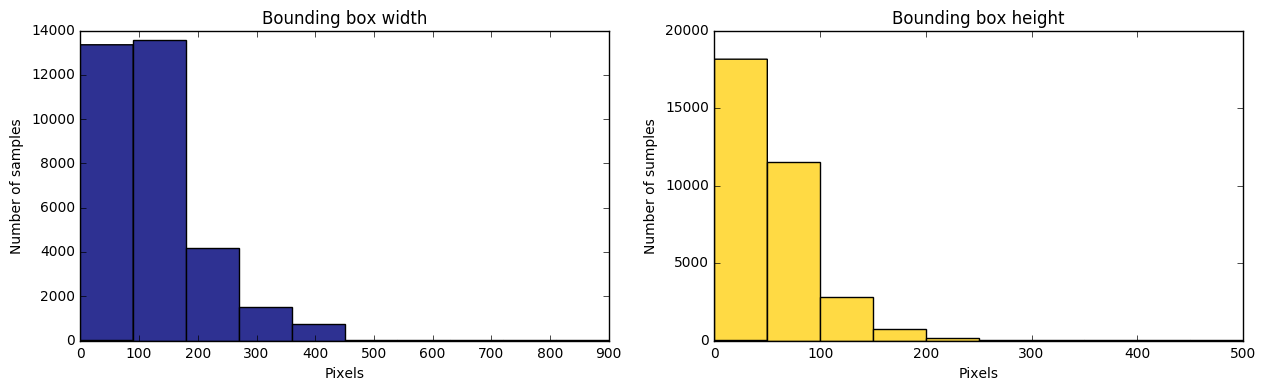

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    
ax1.hist(box_width, range=[0, 900], facecolor='#2E3192')
ax1.set_title('Bounding box width')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('Number of samples')

ax2.hist(box_height, range=[0, 500], facecolor='#FFDA44')
ax2.set_title('Bounding box height')
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Number of sumples')

plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [164]:
def generate_dataset(pickle_files, folder):
    
  dataset = np.ndarray([len(pickle_files), 32, 32, 1], dtype=np.float32)
  labels = np.zeros([len(pickle_files), 6], dtype=np.int32)
  labels.fill(10)
  
  for i in np.arange(len(pickle_files)):
    filename =pickle_files[i]['filename']
    fullname = os.path.join(folder, filename)
    boxes = pickle_files[i]['boxes']
    labels[i,0] = len(boxes)
    top = np.ndarray([len(boxes)], dtype=np.float32)
    left = np.ndarray([len(boxes)], dtype=np.float32)
    height = np.ndarray([len(boxes)], dtype=np.float32)
    width = np.ndarray([len(boxes)], dtype=np.float32)
    for j in np.arange(len(boxes)):
      top[j] = boxes[j]['top']
      left[j] = boxes[j]['left']
      height[j] = boxes[j]['height']
      width[j] = boxes[j]['width']
        
    return dataset, labels

train_dataset, train_labels = generate_dataset(train_dataset, 'train')
test_dataset, test_labels = generate_dataset(test_dataset, 'test')
extra_dataset, extra_labels = generate_dataset(extra_dataset, 'extra')

print (train_dataset.shape, train_labels.shape)
print (test_dataset.shape, test_labels.shape)
print (extra_dataset.shape, extra_labels.shape)

(33402, 32, 32, 1) (33402, 6)
(13068, 32, 32, 1) (13068, 6)
(202353, 32, 32, 1) (202353, 6)


In [165]:
train_data, valid_data, train_labels, valid_labels = ttsplit(train_dataset, train_labels, test_size=0.2, random_state=42)    
train_data2, valid_data2, train_labels2, valid_labels2 = ttsplit(extra_dataset, extra_labels, test_size=0.005, random_state=42)

In [166]:
train_dataset = np.concatenate((train_data, train_data2), axis=0)
train_labels = np.concatenate((train_labels, train_labels2), axis=0)
valid_dataset = np.concatenate((valid_data, valid_data2), axis =0)
valid_labels = np.concatenate((valid_labels, valid_labels2), axis = 0)

In [169]:
print (train_dataset.shape, train_labels.shape)
print (valid_dataset.shape, valid_labels.shape)
print (test_dataset.shape, test_labels.shape)

(228062, 32, 32, 1) (228062, 6)
(7693, 32, 32, 1) (7693, 6)
(13068, 32, 32, 1) (13068, 6)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [170]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
extra_dataset, extra_labels = randomize(extra_dataset, extra_labels)

---
4
---------

---

Finally, let's save the data for later reuse:

In [175]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [176]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1025151216


---
5
---------

---

In [184]:
import math as math

image_size = 32
num_labels = 6
batch_size = 128
initial_learning_rate_value = 0.5
beta1 = 0.001
beta2 = 0.001
beta3 = 0.001
beta4 = 0.001
beta5 = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)    
    
  # learning rate decay
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(initial_learning_rate_value, global_step, 100, 0.95)

  # Hidden layer 1
  h1_size = 1024  
  weights_h1 = tf.Variable(tf.truncated_normal([image_size * image_size, h1_size], stddev=math.sqrt(2.0/(image_size*image_size))))
  biases_h1 = tf.Variable(tf.zeros([h1_size]))
  h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1)

  # Hidden layer 2
  h2_size = 1024
  weights_h2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=math.sqrt(2.0/h1_size)))
  biases_h2 = tf.Variable(tf.zeros([h2_size]))
  h2 = tf.nn.relu(tf.matmul(h1, weights_h2) + biases_h2)

  # Hidden layer 3
  h3_size = 305
  weights_h3 = tf.Variable(tf.truncated_normal([h2_size, h3_size], stddev=math.sqrt(2.0/h2_size)))
  biases_h3 = tf.Variable(tf.zeros([h3_size]))
  h3 = tf.nn.relu(tf.matmul(h2, weights_h3) + biases_h3)

  # Hidden layer 4
  h4_size = 75
  weights_h4 = tf.Variable(tf.truncated_normal([h3_size, h4_size], stddev=math.sqrt(2.0/h3_size)))
  biases_h4 = tf.Variable(tf.zeros([h4_size]))
  h4 = tf.nn.relu(tf.matmul(h3, weights_h4) + biases_h4)

  # Output layer
  weights_o = tf.Variable(tf.truncated_normal([h4_size, num_labels], stddev=math.sqrt(2.0/h4_size)))
  biases_o = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  logits = tf.matmul(h4, weights_o) + biases_o
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + ((beta1 * tf.nn.l2_loss(weights_h1)) + (beta2 * tf.nn.l2_loss(weights_h2)) + (beta3 * tf.nn.l2_loss(weights_h3)) + (beta4 * tf.nn.l2_loss(weights_h4)) + (beta5 * tf.nn.l2_loss(weights_o)))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1)
  train_h2 = tf.nn.relu(tf.matmul(train_h1, weights_h2) + biases_h2)
  train_h3 = tf.nn.relu(tf.matmul(train_h2, weights_h3) + biases_h3)
  train_h4 = tf.nn.relu(tf.matmul(train_h3, weights_h4) + biases_h4)
  train_logits = tf.matmul(train_h4, weights_o) + biases_o
  train_prediction = tf.nn.softmax(train_logits)
  
  valid_h1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1)
  valid_h2 = tf.nn.relu(tf.matmul(valid_h1, weights_h2) + biases_h2)
  valid_h3 = tf.nn.relu(tf.matmul(valid_h2, weights_h3) + biases_h3)
  valid_h4 = tf.nn.relu(tf.matmul(valid_h3, weights_h4) + biases_h4)
  valid_logits = tf.matmul(valid_h4, weights_o) + biases_o
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_h1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1)
  test_h2 = tf.nn.relu(tf.matmul(test_h1, weights_h2) + biases_h2)
  test_h3 = tf.nn.relu(tf.matmul(test_h2, weights_h3) + biases_h3)
  test_h4 = tf.nn.relu(tf.matmul(test_h3, weights_h4) + biases_h4)
  test_logits = tf.matmul(test_h4, weights_o) + biases_o
  test_prediction = tf.nn.softmax(test_logits)

ValueError: Shape (7693, 32, 32, 1) must have rank 2

In [ ]:
num_steps=10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('initialized')
    for step in range(num_steps):
        offset=(step*batch_size)%(train_dataset.shape[0]-batch_size)
        
        batch_data=train_dataset[offset:(offset+batch_size),:]
        batch_labels=train_labels[offset:(offset+batch_size),:]
        
        feed_dict={tf_train_dataset:batch_data,tf_train_labels:batch_labels}
        
        _,l,predictions=session.run([optimizer,loss,train_prediction],feed_dict=feed_dict)
        
        if (step % 1000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
            
        global_step+=1
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
6
---------



---